## In this work, we have performed binary classification task on a small dataset named FSDD (Free Spoken Digit Dataset) using Conventional QCNN (Quantum Convolutional Neural Network) Circuit.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import necessary Libraries


In [41]:
!pip install pennylane

import pennylane as qml
from pennylane import numpy as npq
import numpy as np
from pennylane.templates.embeddings import AngleEmbedding, AmplitudeEmbedding
from math import ceil
from os import listdir
from os.path import join
from scipy.io import wavfile
from matplotlib import pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm

import torch
from torch import nn
import torchvision
from torch.optim import lr_scheduler

import IPython.display as ipd
from librosa.feature import melspectrogram
from librosa import power_to_db
from librosa.effects import trim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# plotting utilities
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.titleweight"] = 'bold'
plt.rcParams["figure.titlesize"] = 'large'
plt.rcParams['figure.dpi'] = 120
plt.style.use('fivethirtyeight')

### Load Dataset and Preprocessing

In [42]:
## Dataset loading

import zipfile
import os

zip_path = '/content/drive/MyDrive/Colab Works/Quantum_1806037/speech mnist/FSDD.zip'
extract_path = '/content/extracted_files/'

# Create a directory to extract the files if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Audio Signal Length Distribution

len(X) = 3000 ; len(y) = 3000


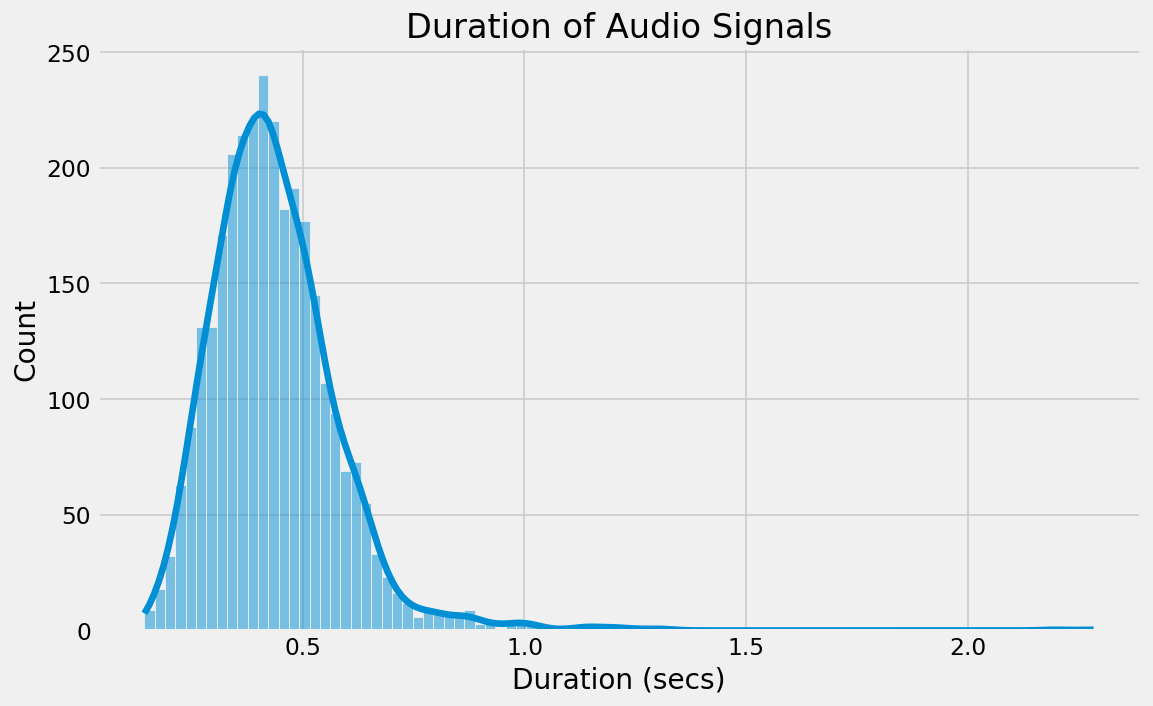

In [43]:
## Audio Signal Length Distribution

files = '/content/extracted_files/FSDD/recordings'
ds_files = listdir(files)

X = []
y = []
for file in ds_files:
    label = int(file.split("_")[0])
    rate, data = wavfile.read(join(files, file))
    X.append(data.astype(np.float32))
    y.append(label)
print(f"len(X) = {len(X)} ; len(y) = {len(y)}")

np.unique(y, return_counts = True)

# All recordings are sampled at the rate of 8 kHZ
rate = 8000

def show_length_distribution(signals, rate=8000):
    sample_times = [len(x) / rate for x in signals]  # Calculate durations

    # Create a single histogram plot with KDE
    plt.figure(figsize=(10, 6))
    sns.histplot(x=sample_times, bins='fd', kde=True)

    title = 'Duration of Audio Signals'
    x_label = 'Duration (secs)'
    y_label = 'Count'

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

    return sample_times

# Assuming X is a list of audio signals
lengths = show_length_distribution(X)

Remove Silence Part

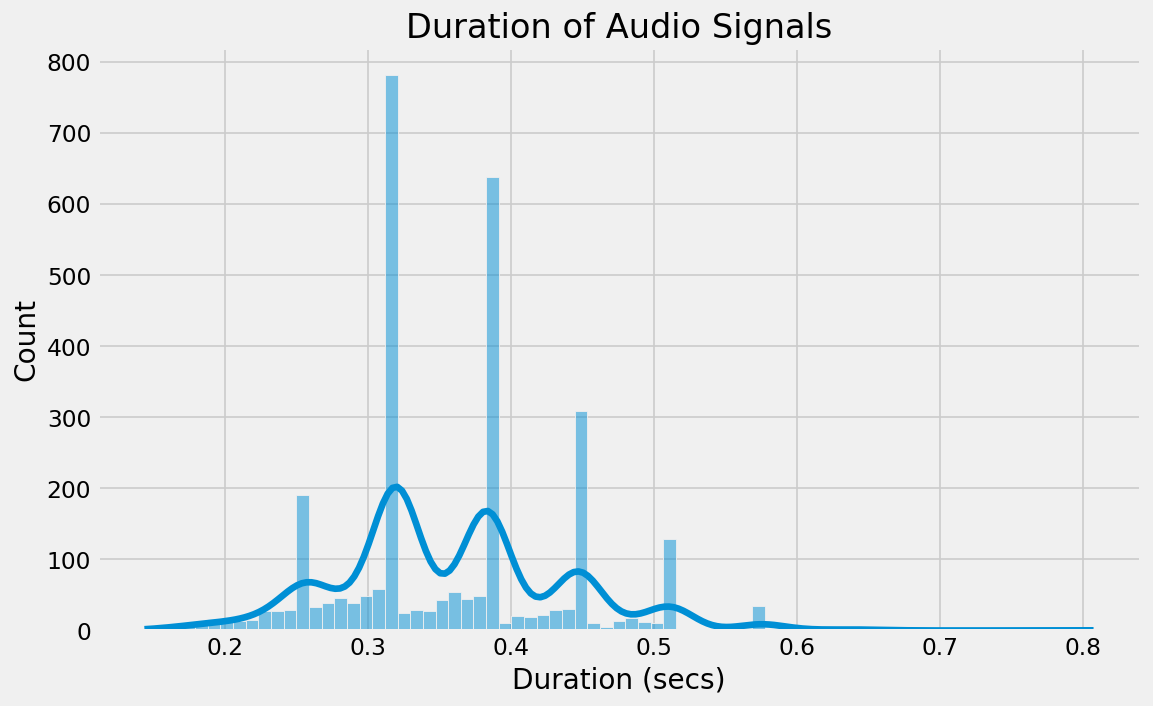

Longest_audio_tr total samples = 6457
Longest_audio_tr duration = 0.807125 secs

Shortest_audio_tr total samples = 1148
Shortest_audio_tr duration = 0.1435 secs


In [44]:
# by default anything below 10 db is considered as silence
def remove_silence(sample, sr= 8000, top_db = 10):
    """This function removes trailing and leading silence periods of audio signals.
    """
    y = np.array(sample, dtype = np.float64)
    # Trim the beginning and ending silence
    yt, _ = trim(y, top_db= top_db)     # librosa.effects.trim()
    return yt

X_tr = [remove_silence(x) for x in X]

show_length_distribution(X_tr);

# longest and shortest audio length after trimming operation on full dataset
Longest_audio_tr = np.argmax([len(x) for x in X_tr])
print(f"Longest_audio_tr total samples = {len(X_tr[Longest_audio_tr])}")
print(f"Longest_audio_tr duration = {len(X_tr[Longest_audio_tr])/rate} secs\n")
Shortest_audio_tr = np.argmin([len(x) for x in X_tr])
print(f"Shortest_audio_tr total samples = {len(X_tr[Shortest_audio_tr])}")
print(f"Shortest_audio_tr duration = {len(X_tr[Shortest_audio_tr])/rate} secs")

Create Feature Vector of Uniform Length

In [45]:
# We will create a matrix with uniform length of columns to allign all recordings.
# All signals will have rate*0.8 data points.

N = int(rate * 0.8) # 0.8 is the upper limit of trimmed audio length
print(f"Number of data points in a single example = {N}")
X_uniform = []
for x in X_tr:
    if len(x) < N:
        X_uniform.append(np.pad(x, (0, N - len(x)), constant_values = (0, 0)))
    else:
        X_uniform.append(x[:N])
print(type(X_uniform))

Number of data points in a single example = 6400
<class 'list'>


Extract MelSpectrogram and calculate mean and standard deviation along frequency dimension to form a 1D Vector

In [46]:
import librosa
import numpy as np

def compute_mean_std_melspectrogram(X, sr, n_mels=32):
    all_features = []

    for audio in tqdm(X):

        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.mean)

        # Normalize
        max = mel_spec_db.max()
        min = mel_spec_db.min()
        norm_mel_spec_db = (mel_spec_db - min) / (max-min)

        # Compute mean and std along the time axis (axis=1)
        means = np.mean(norm_mel_spec_db, axis=1)
        stds = np.std(norm_mel_spec_db, axis=1)

        feature = np.empty(2 * len(means), dtype=means.dtype)
        feature[0::2] = means
        feature[1::2] = stds
        max = feature.max()
        min = feature.min()
        norm_feature = (feature - min) / (max-min)

        all_features.append(norm_feature)
        # print(norm_feature.shape)

    return np.array(all_features)

Extract MelSpectrogram and calculate just mean along frequency dimension to form a 1D Vector

In [47]:
## run this block
## here the normalization is down between -1 to 1
import librosa
import numpy as np
from tqdm import tqdm

def compute_mean_melspectrogram(X, sr, n_mels=32):
    all_features = []

    for audio in tqdm(X):

        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.mean)
        #mel_spec_db = mel_spec  # comment out
        # Normalize
        max_val = mel_spec_db.max()
        min_val = mel_spec_db.min()
        norm_mel_spec_db = 2 * (mel_spec_db - min_val) / (max_val - min_val) - 1  # Normalize to [-1, 1]

        # Compute mean along the time axis (axis=1)
        means = np.mean(norm_mel_spec_db, axis=1)

        feature = np.empty(1 * len(means), dtype=means.dtype)
        feature = means

        max_val = feature.max()
        min_val = feature.min()
        norm_feature = 2 * (feature - min_val) / (max_val - min_val) - 1  # Normalize to [-1, 1]

        all_features.append(norm_feature)

    return np.array(all_features)

# Example usage:
# Replace 'your_audio_data' and 'your_sampling_rate' with actual data and sampling rate
# computed_features = compute_mean_melspectrogram(your_audio_data, your_sampling_rate)


In [48]:
X_mean_std_1D = compute_mean_std_melspectrogram(X_uniform, sr=rate, n_mels=16)
print(f"\nX_mean_std_1D.shape: {X_mean_std_1D.shape}")
print(X_mean_std_1D.max(), X_mean_std_1D.min())

X_mean_1D = compute_mean_melspectrogram(X_uniform, sr=rate, n_mels=16)
print(f"\nX_mean_1D.shape: {X_mean_1D.shape}")
print(X_mean_1D.max(), X_mean_1D.min())

100%|██████████| 3000/3000 [00:24<00:00, 121.04it/s]



X_mean_std_1D.shape: (3000, 32)
1.0 0.0


100%|██████████| 3000/3000 [00:10<00:00, 281.73it/s]


X_mean_1D.shape: (3000, 16)
1.0 -1.0


Lets work with Mean values along frequency dimension of MelSpectrogram

Taking Binary Classes "Zero" and "One"

In [49]:
features = []
Y = []

## taking 'zero' and 'one' [ binary classification task ]
for i in range(len(y)):
    if y[i] == 0:    # '0' for class-0
        Y.append(-1)
        features.append(X_mean_1D[i])     # taking just the mean,
    elif y[i] == 1:  # '1' for class-1
        Y.append(1)
        features.append(X_mean_1D[i])     # taking just the mean,

features = np.array(features)
Y = np.array(Y)

print(features.shape)
print(Y.shape)

(600, 16)
(600,)


Train-Test Splitting

In [50]:
X_train, X_test, Y_train, Y_test = train_test_split(features,
                                                    Y,
                                                    test_size = 0.20,
                                                    random_state = 20)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
print('\n')
print("Train Class Distribution:")
print(np.unique(Y_train, return_counts=True))
print("Test Class Distribution:")
print(np.unique(Y_test, return_counts=True))

# here the inputs are X_train, X_test, Y_train, Y_test
#print(f"X_train.shape = {X_train.shape} X_test.shape = {X_test.shape}")
print(f"minimum(X_train) = {np.min(X_train)}; maximum(X_train) = {np.max(X_train)}")
print(f"minimum(X_test) = {np.min(X_test)}; maximum(X_test) = {np.max(X_test)}")
#print(Y_train)
#print(Y_test)

(480, 16)
(120, 16)
(480,)
(120,)


Train Class Distribution:
(array([-1,  1]), array([235, 245]))
Test Class Distribution:
(array([-1,  1]), array([65, 55]))
minimum(X_train) = -1.0; maximum(X_train) = 1.0
minimum(X_test) = -1.0; maximum(X_test) = 1.0


### Design a 4 qubit QCNN Circuit
For 4 qubit QCNN, one data encoding layer, two convolutional layer and two pooling layers are needed.
For reference of the designed QCNN circuit, see the Article [code publicly accessible]: [Quantum convolutional neural network for classical data classification](https://https://arxiv.org/abs/2108.00661)

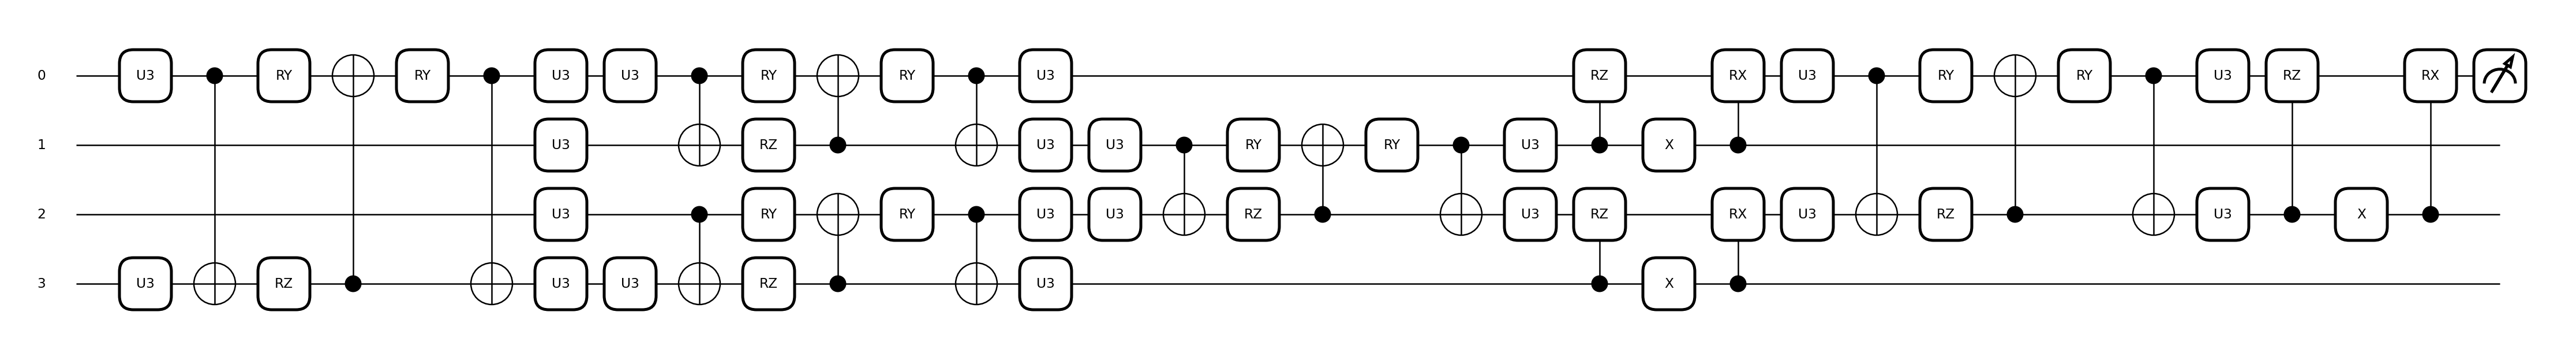

In [51]:
## Defining Special Unitary Grp of Degree 4 ansatz as Convolution ansatz (2 qubit)
def U_SU4(params, wires): # 15 params, 2 wires
    qml.U3(params[0], params[1], params[2], wires=wires[0])
    qml.U3(params[3], params[4], params[5], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[6], wires=wires[0])
    qml.RZ(params[7], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[8], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.U3(params[9], params[10], params[11], wires=wires[0])
    qml.U3(params[12], params[13], params[14], wires=wires[1])

## Defining 2 qubit pooling ansatz
def Pooling_ansatz1(params, wires): #2 params, 2 wires
    qml.CRZ(params[0], wires=[wires[0], wires[1]])
    qml.PauliX(wires=wires[0])
    qml.CRX(params[1], wires=[wires[0], wires[1]])

## Classical to Quantum Encoding
def data_embedding(X, embedding_type = 'Amplitude'):  # 8 wires, 8 inputs
    #AngleEmbedding(X, wires=range(8))
    if embedding_type == 'Amplitude':
        AmplitudeEmbedding(X, wires=range(4), normalize=True)

def conv_layer1(U, params):  #15 params
    U(params, wires=[0, 3])
    for i in range(0, 4, 2):
        U(params, wires=[i, i + 1])
    for i in range(1, 3, 2):
        U(params, wires=[i, i + 1])

def conv_layer2(U, params):  #15 params
    U(params, wires=[0, 2])

def pooling_layer1(V, params):  #2 params
    for i in range(0, 4, 2):
        V(params, wires=[i + 1, i])

def pooling_layer2(V, params):  #2 params
    V(params, wires=[2,0])

def QCNN_structure(U, params, U_params=15):    ## Total 34 trainable parameters
    param1 = params[0:U_params]
    param2 = params[U_params: 2 * U_params]
    param3 = params[2 * U_params: 2 * U_params + 2]
    param4 = params[2 * U_params + 2 : 2 * U_params + 4]

    # Pooling Ansatz1 is used by default
    conv_layer1(U, param1)  #15 params
    pooling_layer1(Pooling_ansatz1, param3) #2 params
    conv_layer2(U, param2)  #15 params
    pooling_layer2(Pooling_ansatz1, param4) #2 params

dev4 = qml.device('default.qubit', wires = 4)
@qml.qnode(dev4)
def circuit4(params):
  QCNN_structure(U_SU4, params)
  result = [qml.expval(qml.PauliZ(0))]
  return result

params = npq.random.randn(34, requires_grad = True)
#inputs = npq.random.randn(4, requires_grad = False)
fig, ax = qml.draw_mpl(circuit4)(params)
fig.show()

In [52]:
dev = qml.device('default.qubit', wires = 4)
@qml.qnode(dev)

### Main QCNN   ###
def QCNN(X, params, U, U_params=15, embedding_type='Amplitude', cost_fn='cross_entropy'):

    # Data Embedding
    data_embedding(X, embedding_type=embedding_type)

    # Quantum Convolutional Neural Network
    if U == 'U_SU4':
        QCNN_structure(U_SU4, params, U_params)
    else:
        print("Invalid Unitary Ansatze")
        return False

    if cost_fn == 'mse':
        result = qml.expval(qml.PauliZ(0))
    elif cost_fn == 'cross_entropy':
        result = qml.probs(wires=0)
    return result

In [53]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    return loss

def cross_entropy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        c_entropy = l * (anp.log(p[l])) + (1 - l) * anp.log(1 - p[1 - l])
        loss = loss + c_entropy
    return -1 * loss

In [54]:
def cost(params, X, Y, U, U_params, embedding_type, circuit, cost_fn):
    if circuit == 'QCNN':
        predictions = [QCNN(x, params, U, U_params, embedding_type, cost_fn=cost_fn) for x in X]

    if cost_fn == 'mse':
        loss = square_loss(Y, predictions)
    elif cost_fn == 'cross_entropy':
        Y_temp = Y.copy()
        Y_temp[Y_temp == -1] = 0
        loss = cross_entropy(Y_temp, predictions)
    return loss

Training Framework

In [55]:
## here each step means 1 batch not 1 epoch.
import numpy as np
from pennylane import numpy as np
import autograd.numpy as anp

# Circuit training parameters
steps = 100
learning_rate = 0.01   # 0.01
batch_size = 16 # 16 or 25
def circuit_training(X_train, Y_train, U, U_params, embedding_type, circuit, cost_fn):
    if circuit == 'QCNN':
        total_params = U_params * 2 + 2 * 2

    params = np.random.randn(total_params, requires_grad=True)    # this requires_grad argument will work, if numpy is imported from pennylane
    opt = qml.NesterovMomentumOptimizer(stepsize=learning_rate)
    #opt =  qml.AdamOptimizer(stepsize=learning_rate, beta1=0.9, beta2=0.99, eps=1e-08)
    loss_history = []

    for it in range(steps):
        batch_index = np.random.randint(0, len(X_train), (batch_size,))
        X_batch = [X_train[i] for i in batch_index]
        Y_batch = [Y_train[i] for i in batch_index]
        params, cost_new = opt.step_and_cost(lambda v: cost(v, X_batch, Y_batch, U, U_params, embedding_type, circuit, cost_fn),
                                                     params)
        loss_history.append(cost_new)
        if it % 10 == 0:
            print("iteration: ", it, " cost: ", cost_new)
    return loss_history, params

In [56]:
def accuracy_test(predictions, labels, cost_fn, binary = True):
    if cost_fn == 'mse':
        if binary == True:
            acc = 0
            for l, p in zip(labels, predictions):
                if np.abs(l - p) < 1:
                    acc = acc + 1
            return acc / len(labels)

        else:
            acc = 0
            for l, p in zip(labels, predictions):
                if np.abs(l - p) < 0.5:
                    acc = acc + 1
            return acc / len(labels)

    elif cost_fn == 'cross_entropy':
        Y_temp = labels.copy()
        Y_temp[Y_temp == -1] = 0
        Y_temp = labels
        acc = 0
        for l,p in zip(Y_temp, predictions):
            if p[0] > p[1]:
                P = 0
            else:
                P = 1
            if P == l:
                acc = acc + 1
        return acc / len(labels)

In [57]:
def Benchmarking(Unitaries, U_num_params, Encodings, circuit, cost_fn):


            U = Unitaries
            U_params = U_num_params
            Encoding = Encodings
            Embedding = 'Amplitude'


            print("\n")
            print("Loss History for " + circuit + " circuits, " + U + " " + Encoding + " with " + cost_fn)
            loss_history, trained_params = circuit_training(X_train, Y_train, U, U_params, Embedding, circuit, cost_fn)   ## Y_train use

            if circuit == 'QCNN':
                predictions = [QCNN(x, trained_params, U, U_params, Embedding, cost_fn) for x in X_test]

            accuracy = accuracy_test(predictions, Y_test, cost_fn, binary)    ## use Y_test
            print("Test Accuracy for " + U + " " + Encoding + " :" + str(accuracy))

            return loss_history

In [58]:
Unitaries = 'U_SU4'
U_num_params = 15
Embedding = 'Amplitude'
binary = True   # keep it True
cost_fn = 'mse'  # use [-1,1] label for 'mse' loss, and [1,0] for 'cross_entropy'

loss_history = Benchmarking(Unitaries, U_num_params, Embedding, circuit='QCNN', cost_fn=cost_fn)



Loss History for QCNN circuits, U_SU4 Amplitude with mse


/usr/local/lib/python3.10/dist-packages/autograd/numpy/numpy_vjps.py:698: ComplexWarning: Casting complex values to real discards the imaginary part
  onp.add.at(A, idx, x)


iteration:  0  cost:  1.0634640681861527
iteration:  10  cost:  0.913733800179769
iteration:  20  cost:  0.832494736322423
iteration:  30  cost:  0.6269077403022527
iteration:  40  cost:  0.6772934845351298
iteration:  50  cost:  0.7096824990278431
iteration:  60  cost:  0.6891909032738629
iteration:  70  cost:  0.6050689839701632
iteration:  80  cost:  0.46713616064323754
iteration:  90  cost:  0.5890624320721592
Test Accuracy for U_SU4 Amplitude :0.8916666666666667


Check Loss Curve

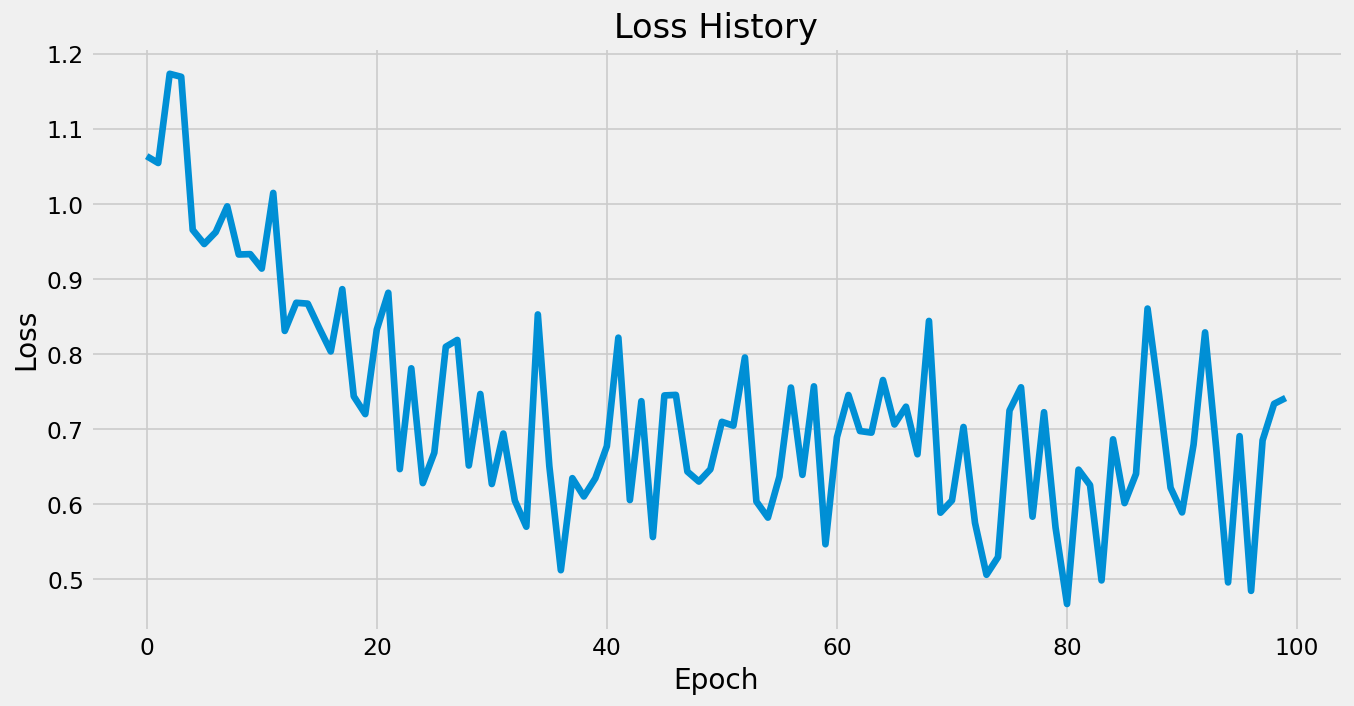

In [59]:
plt.plot(loss_history)
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()